# BLUESKY Demo for ALS Controls

## Summary
This notebook will demonstrate how to:
1. Connect to and directly manipulate ALS devices with Ophyd objects
2. Scan ALS devices with Bluesky "plans"
3. Compose a customized plan using feedback from data analysis to drive acquisition

## Controlling ALS devices directly
First, lets initialize the notebook, importing required packages and setting initial configuration

In [1]:
# Set environment variables. The control layer for Ophyd must be set to use Caproto for ALS devices
import os
os.environ['OPHYD_CONTROL_LAYER'] = 'caproto'

# Import Bluesky and Ophyd components
import ophyd
from bluesky import RunEngine
from bluesky.plans import scan, rel_scan, list_scan, grid_scan, count
from bluesky.callbacks import LivePlot, LiveTable, LiveFitPlot, LiveFit, LiveGrid

# Import special Ophyd classes for ALS hardware
from alsdac.ophyd import Instrument, ScalarInstrument, Motor

# Configure plots to update live while scans run.
from bluesky.utils import install_kicker
%matplotlib notebook
install_kicker()

# Import mathematics packages
import lmfit
import numpy as np

# Import plotting tools
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# Initialize the Bluesky Run Engine
RE = RunEngine({})

Lets create Ophyd objects for some of the devices:

In [2]:
x = Motor('beamline:motors:esp300axis2', name='x')  # X Motor
z = Motor('beamline:motors:esp300axis3', name='z')  # Z Motor
cam = Instrument('beamline:instruments:ptGreyInstrument', name='cam')  # Area detector camera
scalarcam = ScalarInstrument('beamline:instruments:ptGreyInstrument', name='scalarcam') # Scalar detector

We can get and set values to these devices:

In [91]:
x.position  # Last read position (currently limited use without callbacks from LabView)

-2.0

In [92]:
x.user_readback.get(use_monitor=False)  # Read the position

-2.0

In [108]:
status = x.set(-2.)  # Move the X Motor
ophyd.status.wait(status)  # Wait until the move completes
print(status)  # Show that the move is finished and successful

MoveStatus(done=True, pos=x, elapsed=0.2, success=True, settle_time=0.0)


<IPython.core.display.Javascript object>


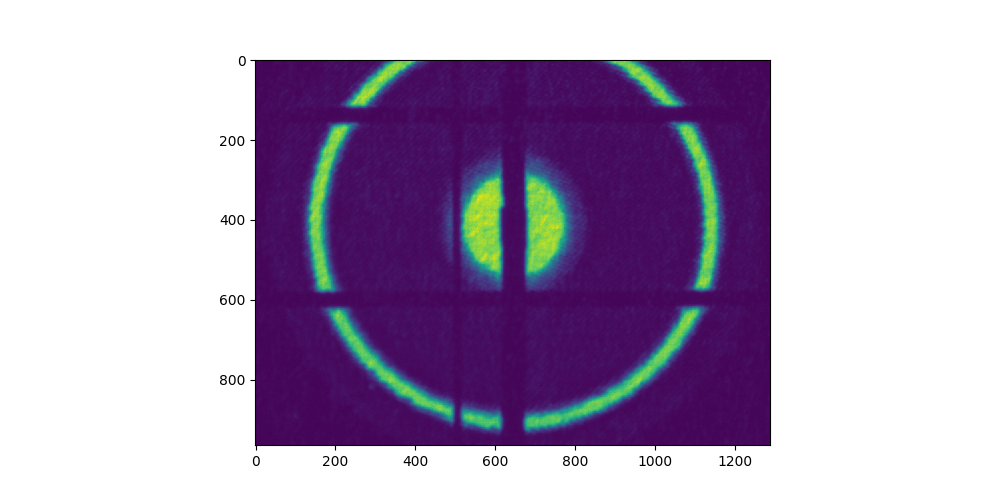

In [112]:
cam.trigger()  # Trigger the area detector
data = cam.read()['cam_image']['value']  # Read the acquired image
plt.imshow(data)

You *could* try automating a coordinated movement or acquisition of multiple devices, but let Bluesky do this for you!

## Using Bluesky "plans" for automation

Suggested reading, introduction to Bluesky: http://try.nsls2.bnl.gov/?urlpath=notebooks/tutorials/Hello%20Bluesky.ipynb

"Plans" are scripted, coordinated actions spanning multiple devices. Here are some simple examples using the builtin `scan` plan.

In [3]:
RE(scan([scalarcam], x, -3, -1, 10), LiveTable([scalarcam.image, x]))  # A scan of the scalar detector moving in x

+-----------+------------+-----------------+------------+-----------------+
|   seq_num |       time | scalarcam_image |          x | x_user_setpoint |
+-----------+------------+-----------------+------------+-----------------+
|         1 | 10:47:11.7 |           43072 |         -3 |              -3 |
|         2 | 10:47:16.0 |           27760 |         -3 |              -3 |
|         3 | 10:47:20.1 |           26736 |         -3 |              -3 |
|         4 | 10:47:24.4 |           34000 |         -2 |              -2 |
|         5 | 10:47:28.6 |          383728 |         -2 |              -2 |
|         6 | 10:47:32.9 |          506400 |         -2 |              -2 |
|         7 | 10:47:36.9 |          526480 |         -2 |              -2 |
|         8 | 10:47:41.0 |          496800 |         -1 |              -1 |
|         9 | 10:47:46.1 |          501312 |         -1 |              -1 |
|        10 | 10:47:51.0 |          476816 |         -1 |              -1 |
+-----------

('3e2ccf36-a332-4275-a699-2588fd8469a6',)

<IPython.core.display.Javascript object>


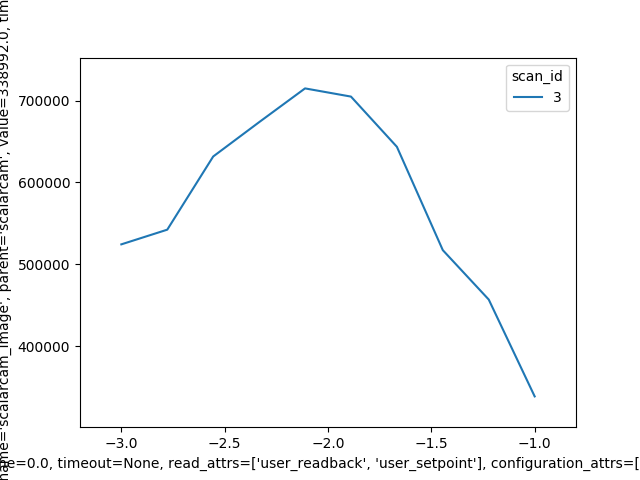

/home/rp/PycharmProjects/ophyd/venv/lib/python3.7/site-packages/matplotlib/legend.py:1192: MatplotlibDeprecationWarning: 
Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.
  message="Legend.draggable() is drepecated in "


('e5379acd-a2dd-419b-8869-9c58a15f8401',)

In [33]:
RE(scan([scalarcam], x, -3, -1, 10), LivePlot(scalarcam.image, x))  # The same scan, displayed as a plot

<IPython.core.display.Javascript object>


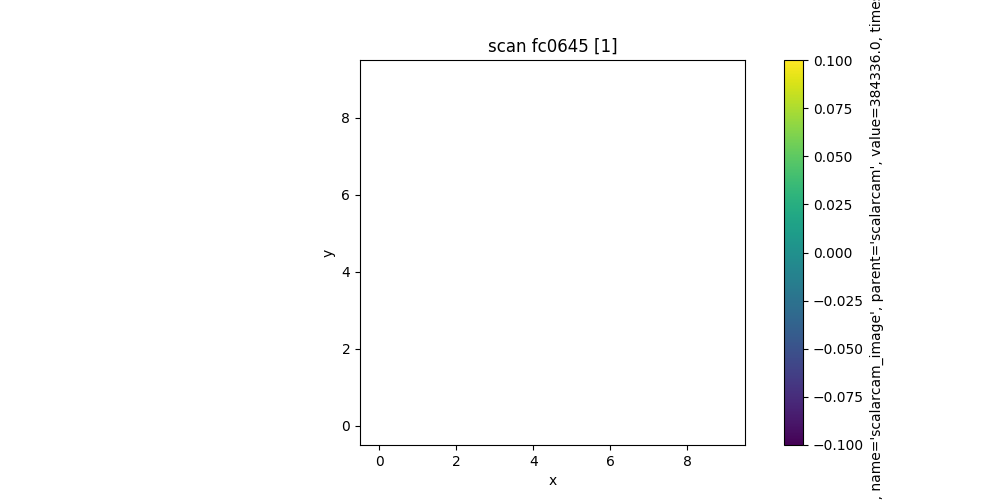

FailedStatus: MoveStatus(done=True, pos=z, elapsed=797.2, success=False, settle_time=0.0)

In [125]:
RE(grid_scan([scalarcam], x, -3, -1, 10, z, -1, 1, 10, False), LiveGrid((10, 10), scalarcam.image))

You can apply also live fits to scans, and extract parameters:

<IPython.core.display.Javascript object>


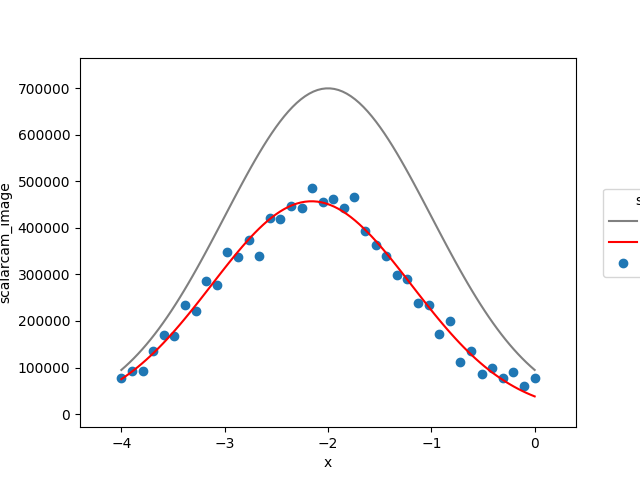

/home/rp/PycharmProjects/ophyd/venv/lib/python3.7/site-packages/matplotlib/legend.py:1192: MatplotlibDeprecationWarning: 
Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.
  message="Legend.draggable() is drepecated in "


('579ba07b-60e9-419c-84fe-9675be2652af',)

In [73]:
def gaussian(x, A, sigma, x0):
    return A*np.exp(-(x - x0)**2/(2 * sigma**2))

model = lmfit.Model(gaussian)
init_guess = {'A': 700000,
              'sigma': lmfit.Parameter('sigma',1, min=0),
              'x0': -2.}

fig, ax = plt.subplots()
lf = LiveFit(model, 'scalarcam_image', {'x': 'x'}, init_guess)
lpf = LiveFitPlot(lf, color='r', ax=ax)
lp = LivePlot('scalarcam_image', 'x', ax=ax, marker='o', linestyle='none')
RE(scan([scalarcam], x, -4, -0, 40), [lpf,lp])
print('Mean:', lf.result.params['x0'])

[WIP] You can also compose multiple scans into a single plan. This custom plan will scan/fit/optimize x, then z, then x again, aligning the detector to the beam center.

In [68]:
def align_plan():
    yield from scan([scalarcam], x, -4, -0, 40)
    if x.position<-4 or x.position>0:
        raise ValueError
    print('Aligned to x = ',lf.result.params['x0'].value)
    x.set(lf.result.params['x0'].value)
    yield from scan([scalarcam], z, -2, 2, 40)
    if z.position>2 or z.position<-2:
        raise ValueError
    z.set(lf.result.params['x0'].value)
    print('Aligned to z = ',lf.result.params['x0'].value)
    yield from scan([scalarcam], x, -3, -1, 40)
    if x.position<-3 or x.position>-1:
        raise ValueError
    x.set(lf.result.params['x0'].value)
    print('Aligned to x = ',lf.result.params['x0'].value)
RE(align_plan())

Aligned to x =  -2.1015591147973236
Aligned to z =  -2.1015591147973236
Aligned to x =  -2.1015591147973236


('3f3de318-49cc-43dc-8090-16c6a3d666c0',
 '680bb4d3-1dbc-4441-8be4-9a546a0c7854',
 '669af172-7a16-4f48-9307-21c9616b5890')

We can interrupt the kernel to stop a scan, and then either abort or resume the scan:

In [70]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...


['46f8c9e8-4cfa-4692-b67a-20aaa6a5f4c6']

## Connecting Controls/Acquisition and Data Analysis

### Example 1: Inline AgB Calibration

/home/rp/PycharmProjects/ophyd/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
  File "<ipython-input-85-68fb283d15f8>", line 72, in calibrate_agb
    calibrant1stpeak = calibrant.ALL_CALIBRANTS['AgBh'].dSpacing[N-1]
  File "<ipython-input-85-68fb283d15f8>", line 88, in <module>
    calibrant = calibrant.ALL_CALIBRANTS['AgBh']


<IPython.core.display.Javascript object>


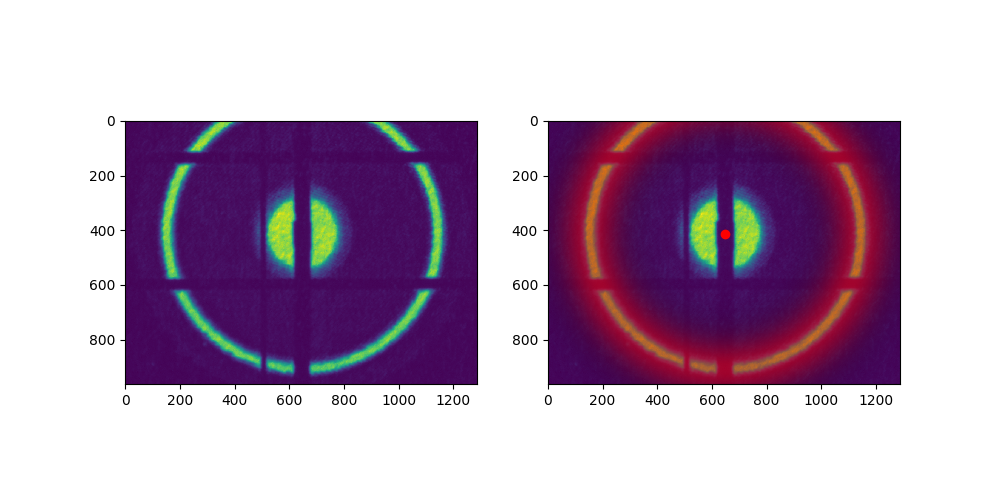

In [85]:
from scipy import optimize
from scipy import signal
from pyFAI import calibrant, geometry

wavelet = signal.ricker # wavelet of choice
widths = np.arange(1, 20) # range of widths of the ricker wavelet to search/evaluate
max_distances = widths / 8. # ridgeline connectivity threshold; smaller values gives more peaks; larger values considers overlapping peaks as one
gap_thresh = 4 # threshold number of rows for ridgeline connectivity; smaller values gives more peaks
min_length = 3 # minimum ridgeline length; smaller values gives more peaks
min_snr = 2 # Minimum SNR
noise_perc = 10 # percentile of points below which to consider noise
h = 3 # number of points skipped in finite differences
truncationlow = 10 # low q truncation for zeros
truncationhigh = 50 # high q truncation for zeros

wavelength = 124.e-12
pixelsize = 172.e-6


def findpeaks(x, y):
    peaks = signal.find_peaks_cwt(y,widths,wavelet,max_distances,gap_thresh,min_length,min_snr,noise_perc)
    peaks = peaks[1:]
    return list(np.array(np.vstack([x[peaks.astype(int)],y[peaks.astype(int)],peaks])))


def pixel_2Dintegrate(data, center, mask=None):

    # mask data
    data = data * mask

    # calculate data radial profile
    x, y = np.indices(data.shape)
    r = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel(), (mask).ravel())
    radialprofile = tbin / nr

    return radialprofile

def center_approx(img, mask):
    
    con = signal.fftconvolve(img.astype(int)*mask*(img>0), img.astype(int)*mask*(img>0)) / np.sqrt(signal.fftconvolve(np.ones_like(img), np.ones_like(img)))

    cen = np.array(np.unravel_index(con.argmax(), con.shape)) / 2.
    return cen

def calibrate_agb(data, wavelength=wavelength, pixelsize=pixelsize, mask=None):
    if mask is None: mask = np.ones_like(data)
        
    center = center_approx(data, mask)

    radialprofile = pixel_2Dintegrate(data, center, mask=mask)

    peaks = np.array(findpeaks(np.arange(len(radialprofile)), radialprofile)).T

    peaks = peaks[peaks[:, 1].argsort()[::-1]]
    
    for peak in peaks:
        if peak[0] > 15 and not np.isinf(peak[1]):  ####This thresholds the minimum sdd which is acceptable
            bestpeak = peak[0]
            # print peak
            break

    N = 1
    # guess which order is the first
    stds=[np.std((peaks[:,0]/(np.arange(len(peaks))+i))[:4]) for i in range(1,5)]
    if min(stds)<5: # threshold accepting peak as higher N
        N=np.argmin(stds)+1 # index of the first detected peak

    calibrant1stpeak = calibrant.ALL_CALIBRANTS['AgBh'].dSpacing[N-1]

    # Calculate sample to detector distance for lowest q peak
    tth = 2 * np.arcsin(0.5 * wavelength / calibrant1stpeak / 1.e-10)
    tantth = np.tan(tth)
    sdd = bestpeak * pixelsize / tantth

    return center, sdd


data = cam.read()['cam_image']['value']
center, sdd = calibrate_agb(data)

ai = geometry.Geometry()
ai.detector = detectors.Detector(max_shape=data.shape, pixel1=pixelsize, pixel2=pixelsize)
ai.setFit2D(sdd*1000, center[1], center[0], pixelX=pixelsize*1e6, pixelY=pixelsize*1e6)
calibrant = calibrant.ALL_CALIBRANTS['AgBh']
calibrant.set_wavelength(wavelength)
simulated_calibrant = calibrant.fake_calibration_image(ai, Imax=1)

ax = plt.subplot(1,2,1)
ax.imshow(data)
ax = plt.subplot(1,2,2)
ax.imshow(data)
ax.plot([center[1]],[center[0]],'ro')
cmap = colors.LinearSegmentedColormap.from_list('transparent_red',[[0,0,0,0],[1,0,0,.5]],256)

ax.imshow(simulated_calibrant, cmap=cmap)



In [78]:
ai.getFit2D()

{'pixelX': 0.000172,
 'pixelY': 0.000172,
 'splineFile': None,
 'directDist': 4007.767952248246,
 'centerX': 414.0,
 'centerY': 647.5,
 'tilt': 0.0,
 'tiltPlanRotation': 0.0}

In [76]:
ai.setFit2D?

In [75]:
center

array([414. , 647.5])

In [ ]:
# AgB calibration
# Live peak finding, tracking
# ML crystal lattice determination
# Saturation prevention
# Out of process analysis/visualization
